# Image Classification on CIFAR-10

In this example we will show how _JaxSGMC_ can be used to set up and train a neural network. The objective is to perform image classification on the dataset [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) which consists of 60000 32x32 images. We will use the [MobileNet](https://arxiv.org/abs/1704.04861) architecture implemented by [Haiku](https://github.com/deepmind/dm-haiku).

We import the necessary libraries, and ignore certain warnings.

In [1]:
import os
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

from jax import jit, random, numpy as jnp, scipy as jscipy, tree_map
from jax_sgmc import data, potential, alias
from jax_sgmc.data.numpy_loader import NumpyDataLoader
import tensorflow as tf
import haiku as hk
import optax
import tree_math
from functools import partial
import numpy as onp
import matplotlib.pyplot as plt

We set a seed for each library where we will use stochastic functionalities.

In [2]:
onp.random.seed(123)
tf.random.set_seed(123)
key = random.PRNGKey(123)

Due to conflicts between JAX and Tensorflow we make sure that Tensorflow cannot see any GPU devices.

In [3]:
tf.config.set_visible_devices([], device_type="GPU")

Now we continue by loading the data, setting hyper-parameters and rescaling the images from 32x32 to 112x112. The MobileNet architecture shows better performance with larger images. Then we also split the data and organize it into DataLoaders.

We try to balance between a large and a small (mini-)batch size since a larger choice usually leads to more robust updates while a smaller one leads to faster computation, in our view a (mini-)batch size of 256 is suitable. We wish to go over the full dataset 200 times, thus we calculate how many iterations are necessary depending on the chosen (mini-)batch size (here 39000 iterations). We set the burn-in phase to cover 90% of the iterations and only consider samples from the final 10% of the iterations (here 35100 burn-in iterations). Here also thinning will be applied so that a fixed number of parameters is accepted - in our case 20 parameters are accepted.
For the learning rate we start with 0.001 (common choice for deep learning models) and calculate a final learning rate with a decay of 0.33.

In [4]:
# Configuration parameters
cached_batches = 10
num_classes = 10

# Load dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Rescaling images
train_images = tf.image.resize(
    train_images,
    (112, 112),
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=True
)
test_images = tf.image.resize(
    test_images,
    (112, 112),
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=True
)

# Hyper-parameters
batch_size = 256
epochs = 200
iterations_per_epoch = int(train_images.shape[0] / batch_size)
iterations = epochs * iterations_per_epoch
burn_in_size = (epochs - 20) * iterations_per_epoch
lr_first = 0.001
gamma = 0.33
lr_last = lr_first * (iterations) ** (-gamma)
accepted_samples = 20

Now we split the data. 50000, 5000 and 5000 images are used as training, validation and test datasets.

In [5]:
# Split data and organize into DataLoaders
train_loader = NumpyDataLoader(image=train_images, label=onp.squeeze(train_labels))
test_loader = NumpyDataLoader(image=test_images[:test_labels.shape[0] // 2, :, :, :],
                              label=test_labels[:test_labels.shape[0] // 2, :])
val_loader = NumpyDataLoader(image=test_images[test_labels.shape[0] // 2:, :, :, :],
                             label=test_labels[test_labels.shape[0] // 2:, :])


Now we need to obtain an initial batch of data such that the neural network can be initialized with a batch. The `random_reference_data` function initialized data access and allows randomly drawing mini-batches; it returns functions for initialization of a new reference data state, for getting a minibatch from the data state and for releasing the DataLoader once all computations have been done.

In [6]:
train_batch_fn = data.random_reference_data(train_loader, cached_batches, batch_size)
val_batch_init, val_batch_get, val_release = data.random_reference_data(val_loader, cached_batches, batch_size)
test_batch_init, test_batch_get, test_release = data.random_reference_data(test_loader, cached_batches, batch_size)

train_batch_init, train_batch_get, _ = train_batch_fn
init_train_data_state = train_batch_init()
batch_state, batch_data = train_batch_get(init_train_data_state, information=True)
init_batch, info_batch = batch_data
val_init_state, val_init_batch = test_batch_get(val_batch_init(), information=True)
test_init_state, test_init_batch = test_batch_get(test_batch_init(), information=True)

Now the MobileNet architecture can be defined using the Haiku syntax.

In [7]:
def init_mobilenet():
    @hk.transform
    def mobilenetv1(batch, is_training=True):
        images = batch["image"].astype(jnp.float32)
        mobilenet = hk.nets.MobileNetV1(num_classes=num_classes, use_bn=False)
        logits = mobilenet(images, is_training=is_training)
        return logits

    return mobilenetv1.init, mobilenetv1.apply

In [8]:
init, apply_mobilenet = init_mobilenet()
apply_mobilenet = jit(apply_mobilenet)
init_params = init(key, init_batch)

At this point we stop to see if we can apply the Mobilenet network to a minibatch of data and if the obtained logits make sense.

In [9]:
# Sanity-check prediction
logits = apply_mobilenet(init_params, None, init_batch)
print(logits)

[[ 2.64722737e-04  7.68832615e-06 -3.47102876e-04 ... -7.99813206e-05
  -2.19641355e-04  4.75208333e-04]
 [ 1.75473673e-04  3.78734148e-06 -2.14029977e-04 ... -3.50231603e-05
  -1.19152261e-04  2.93968478e-04]
 [ 1.11978923e-04 -2.58127366e-05 -1.80081799e-04 ... -2.90761418e-05
  -7.82685966e-05  2.46878073e-04]
 ...
 [ 1.45877129e-04 -1.07945561e-05 -1.91932806e-04 ... -4.65796147e-05
  -1.20243625e-04  2.87771982e-04]
 [ 2.50594225e-04  1.03299026e-05 -2.62956979e-04 ... -6.36904660e-05
  -1.62467084e-04  3.73987947e-04]
 [ 2.51225487e-04  2.30743499e-05 -2.93478079e-04 ... -7.16412542e-05
  -1.87586003e-04  3.73031915e-04]]


Now we define the log-likelihood and log-prior. For multiclass classification the log-likelihood is the negative cross entropy. We set a log gaussian prior centered at 0 and with a standard deviation of 10 on the weights.

In [10]:
# Initialize potential with log-likelihood
def log_likelihood(sample, observations):
    logits = apply_mobilenet(sample["w"], None, observations)
    # Log-likelihood is negative cross entropy
    log_likelihood = -optax.softmax_cross_entropy_with_integer_labels(logits, observations["label"])
    return log_likelihood


# Set gaussian prior
prior_scale = 10.
def log_gaussian_prior(sample):
    prior_params = sample["w"]
    gaussian = partial(jscipy.stats.norm.logpdf, loc=0., scale=prior_scale)
    priors = tree_map(gaussian, prior_params)
    return tree_math.Vector(priors).sum()

We have defined the log-likelihood to accept a batch of data, and we take care to set the `is_batched=True` when calling `minibatch_potential`.

It should be noted that it is possible to provide an additional state and then the log-likelihood signature would also consider a state parameter:
The log-likelihood signature changes from:   (Sample, Data) -> Likelihood
                                     to :   (State, Sample, Data) -> Likelihood, NewState
if `has_state` is set to true.

We want to sample the neural network parameters; we denote them as `'w'` and use the initial parameters as a starting sample.

In [11]:
potential_fn = potential.minibatch_potential(prior=log_gaussian_prior,
                                             likelihood=log_likelihood,
                                             is_batched=True,
                                             strategy='vmap')

# Define sample (of model parameters)
sample = {"w": init_params}

# Sanity-check likelihoods
_, returned_likelihoods = potential_fn(sample, batch_data, likelihoods=True)

Now we use the `alias.py` module to set up a [pSGLD sampler with an RMSProp preconditioner](https://arxiv.org/abs/1512.07666). The potential function, DataLoader for training, and a set of hyperparameters need to be passed in order to initialize the sampler. In this case a polynomial step size scheduler is used to control the learning rate and thinning is applied to accept only a fixed number of parameters.

In [12]:
# Create pSGLD sampler (with RMSProp precodntioner)
sampler = alias.sgld(potential_fn=potential_fn,
                     data_loader=train_loader,
                     cache_size=cached_batches,
                     batch_size=batch_size,
                     first_step_size=lr_first,
                     last_step_size=lr_last,
                     burn_in=burn_in_size,
                     accepted_samples=accepted_samples,
                     rms_prop=True,
                     progress_bar=True)

The sampler can now be used to sample parameters. We provide the number of iterations and run the MCMC sampling algorithm. We take the first (and only) chain indexed by `[0]` and from this we obtain the sampled variables.

In [13]:
# Perform sampling
results = sampler(sample, iterations=iterations)
results = results[0]['samples']['variables']

/home/student/ana/venv38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:173: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


2023-06-12 12:22:27.815458: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[1,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,8192,55,55]{3,2,1,0}, f32[32,256,55,55]{3,2,1,0}, f32[32]{0}, f32[1,32,3,3]{3,2,1,0}), window={size=55x55 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convBiasActivationForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0.0099999997764825821}"


2023-06-12 12:22:29.317933: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[1,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,16384,55,55]{3,2,1,0}, f32[64,256,55,55]{3,2,1,0}, f32[64]{0}, f32[1,64,3,3]{3,2,1,0}), window={size=55x55 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convBiasActivationForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0.0099999997764825821}"


2023-06-12 12:22:31.747327: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[1,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,131072,7,7]{3,2,1,0}, f32[512,256,7,7]{3,2,1,0}, f32[512]{0}, f32[1,512,3,3]{3,2,1,0}), window={size=7x7 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=512, custom_call_target="__cudnn$convBiasActivationForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0.0099999997764825821}"


2023-06-12 12:22:32.082970: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[1,1024,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,262144,4,4]{3,2,1,0}, f32[1024,256,4,4]{3,2,1,0}, f32[1024]{0}, f32[1,1024,3,3]{3,2,1,0}), window={size=4x4 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=1024, custom_call_target="__cudnn$convBiasActivationForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0.0099999997764825821}"


2023-06-12 12:22:32.405819: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[1,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32768,28,28]{3,2,1,0}, f32[128,256,28,28]{3,2,1,0}, f32[128]{0}, f32[1,128,3,3]{3,2,1,0}), window={size=28x28 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convBiasActivationForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0.0099999997764825821}"


2023-06-12 12:22:33.784852: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:825] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[1,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32768,29,29]{3,2,1,0}, f32[128,256,27,27]{3,2,1,0}, f32[128]{0}, f32[1,128,3,3]{3,2,1,0}), window={size=27x27}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convBiasActivationForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0.0099999997764825821}"


[Step 0/39000](0%) Collected 0 of 20 samples...


[Step 1950/39000](5%) Collected 0 of 20 samples...


[Step 3900/39000](10%) Collected 0 of 20 samples...


[Step 5850/39000](15%) Collected 0 of 20 samples...


[Step 7800/39000](20%) Collected 0 of 20 samples...


[Step 9750/39000](25%) Collected 0 of 20 samples...


[Step 11700/39000](30%) Collected 0 of 20 samples...


[Step 13650/39000](35%) Collected 0 of 20 samples...


[Step 15600/39000](40%) Collected 0 of 20 samples...


[Step 17550/39000](45%) Collected 0 of 20 samples...


[Step 19500/39000](50%) Collected 0 of 20 samples...


[Step 21450/39000](55%) Collected 0 of 20 samples...


[Step 23400/39000](60%) Collected 0 of 20 samples...


[Step 25350/39000](65%) Collected 0 of 20 samples...


[Step 27300/39000](70%) Collected 0 of 20 samples...


[Step 29250/39000](75%) Collected 0 of 20 samples...


[Step 31200/39000](80%) Collected 0 of 20 samples...


[Step 33150/39000](85%) Collected 0 of 20 samples...


[Step 35100/39000](90%) Collected 0 of 20 samples...


[Step 37050/39000](95%) Collected 8 of 20 samples...


Now the obtained samples provide 20 neural networks which we wish to evaluate. We define a function which performs the evaluation. Within this function we use the `full_data_mapper` from _JaxSGMC_ to map over the full dataset (either training, validation or test dataset - depending on the evaluation settings) in batches of 1000 images. To do this, we define also the `fetch_logits` function which takes the parameters (current sample) and applies a neural network with these parameters on a batch of data and returns the predictions (logits). Then we collect the logits for the full dataset and for each neural network.

Then we proceed with an aggregation of the results of the ensemble. Two common approaches are taken here: hard voting and soft voting (also known as hard and soft aggregation). For hard voting the logits are used to predict a class and then the class predicted by the majority is taken as the ensemble prediction. In the case of soft voting the logits are converted to probabilities and the mean of all ensemble members is taken - the class with the highest mean probability is then chosen as the ensemble prediction. This is similar to [sklearn.ensemble.VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html).

Furthermore, we are interested in investigating if ensemble certainty correlates with higher accuracy. We calculate the ensemble certainty as a measure of agreement among the members; we set the certainty to be the ration of the number of members in the majority and all members - if all members predict the same class then the certainty is 100%. Here we calculate the accuracies where the certainty is >= 50%, 60%, 70%, 80%, 90% and 100%.

Finally, we observe how the ensemble predictions provide a gateway to UQ when making individual predictions. We take five images drawn at random from the dataset and plot the predicted probabilities as box-plots. This gives an insight into the uncertainty in the prediction.

In [14]:
def evaluate_model(results, loader, evaluation="hard", dataset="training"):
    my_parameter_mapper, sth_to_remove = data.full_data_mapper(loader, 1, 1000)

    @jit
    def fetch_logits(batch, mask, carry):
        temp_logits = apply_mobilenet(params, None, batch, is_training=False)
        return temp_logits, carry + 1

    if dataset == "validation" or dataset == "test":
        logits_all = onp.empty((accepted_samples, test_labels.shape[0] // 2, num_classes))
    else:
        logits_all = onp.empty((accepted_samples, train_labels.shape[0], num_classes))
    # Go over sampled parameters (NNs)
    for j in range(accepted_samples):
        params = tree_map(lambda x: jnp.array(x[j]), results['w'])
        # Collect logits
        out, _ = my_parameter_mapper(fetch_logits, 0, masking=True)
        logits_all[j, :, :] = out.reshape(-1, 10)

    # Hard-voting: obtain predicted class labels from each model and use the most frequently predicted class
    if evaluation == "hard":
        class_predictions = onp.argmax(logits_all, axis=-1)
        hard_class_predictions = onp.apply_along_axis(lambda x: onp.bincount(x, minlength=10).argmax(), 0,
                                                      class_predictions)
        if dataset == "validation":
            accuracy = sum(hard_class_predictions == onp.squeeze(test_labels[test_labels.shape[0] // 2:, :])) / (
                        test_labels.shape[0] // 2)
        elif dataset == "test":
            accuracy = sum(hard_class_predictions == onp.squeeze(test_labels[:test_labels.shape[0] // 2, :])) / (
                        test_labels.shape[0] // 2)
        else:
            accuracy = sum(hard_class_predictions == onp.squeeze(train_labels)) / train_labels.shape[0]
        print((dataset == "training") * "Training" + (dataset == "validation") * "Validation" + (
                dataset == "test") * "Test" + " Hard-Voting Accuracy: " + str(
            accuracy * 100) + "%")

        # Calculating certainty (per image)
        certainty = onp.count_nonzero(class_predictions == hard_class_predictions, axis=0) / accepted_samples

        # Evaluating accuracy when certainty is above a fixed threshold
        accuracy_over_certainty = []
        for k in range(6):
            if dataset == "validation":
                accuracy_over_certainty.append(
                    sum(hard_class_predictions[onp.asarray(certainty >= (0.5 + 0.1 * k))] ==
                        onp.squeeze(onp.asarray(test_labels[test_labels.shape[0] // 2:, :]))[
                            onp.asarray(certainty >= (0.5 + 0.1 * k))]) / sum(certainty >= (0.5 + 0.1 * k)) * 100)
            elif dataset == "test":
                accuracy_over_certainty.append(
                    sum(hard_class_predictions[onp.asarray(certainty >= (0.5 + 0.1 * k))] ==
                        onp.squeeze(onp.asarray(test_labels[:test_labels.shape[0] // 2, :]))[
                            onp.asarray(certainty >= (0.5 + 0.1 * k))]) / sum(certainty >= (0.5 + 0.1 * k)) * 100)
            else:
                accuracy_over_certainty.append(
                    sum(hard_class_predictions[onp.asarray(certainty >= (0.5 + 0.1 * k))] == onp.squeeze(
                        train_labels[onp.asarray(certainty >= (0.5 + 0.1 * k))])) / sum(
                        certainty >= (0.5 + 0.1 * k)) * 100)
        print((dataset == "training") * "Training" + (dataset == "validation") * "Validation" + (
                dataset == "test") * "Test" + " Hard-Voting Accuracy-Over-Certainty: " + str(
            accuracy_over_certainty) + "%")

    # Soft-voting: obtain predicted probabilities from each model use the mean of these probabilities to pick a class
    probabilities = onp.exp(logits_all)
    mean_probabilities = onp.mean(probabilities, axis=0)
    soft_class_predictions = onp.argmax(mean_probabilities, axis=-1)
    if dataset == "validation":
        accuracy = sum(soft_class_predictions == onp.squeeze(test_labels[test_labels.shape[0] // 2:, :])) / (
                    test_labels.shape[0] // 2)
        random_samples = onp.random.randint(0, test_labels.shape[0] // 2 - 1, 5)
    elif dataset == "test":
        accuracy = sum(soft_class_predictions == onp.squeeze(test_labels[:test_labels.shape[0] // 2, :])) / (
                    test_labels.shape[0] // 2)
        random_samples = onp.random.randint(0, test_labels.shape[0] // 2 - 1, 5)
    else:
        accuracy = sum(soft_class_predictions == onp.squeeze(train_labels)) / train_labels.shape[0]
        random_samples = onp.random.randint(0, train_labels.shape[0] - 1, 5)
    print((dataset == "training") * "Training" + (dataset == "validation") * "Validation" + (
            dataset == "test") * "Test" + " Soft-Voting Accuracy: " + str(accuracy * 100) + "%")

    # Plotting five randomly chosen samples
    fig, ax = plt.subplots(1, 5, figsize=(10.8, 5))
    for i in range(len(random_samples)):
        ax[i].boxplot(probabilities[:, random_samples[i], :])
        ax[i].set_title("Image " + str(random_samples[i]))
        ax[i].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    fig.tight_layout(pad=0.2)
    plt.savefig("UQ_CIFAR10_" + (dataset == "training") * "Training" + (dataset == "validation") * "Validation" + (
            dataset == "test") * "Test" + ".pdf", format="pdf")
    plt.show()

We perform evaluation for the training, validation and test set separately.

Training Hard-Voting Accuracy: 66.156%


Training Hard-Voting Accuracy-Over-Certainty: [68.9217713448781, 72.9949537014355, 77.10252388421502, 81.11635750421586, 84.99628314198398, 89.91476426059486]%


/tmp/ipykernel_15397/170752579.py:63: RuntimeWarning: overflow encountered in exp
  probabilities = onp.exp(logits_all)


Training Soft-Voting Accuracy: 64.696%


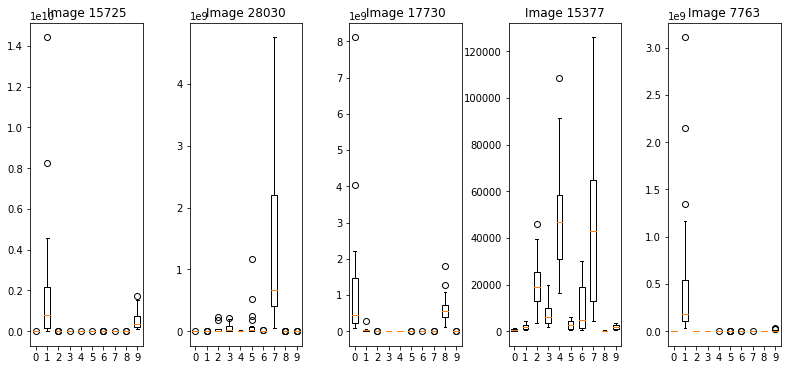

Validation Hard-Voting Accuracy: 56.379999999999995%
Validation Hard-Voting Accuracy-Over-Certainty: [58.879930268032254, 61.838161838161845, 65.55232558139535, 69.02380131079683, 73.75054324206867, 79.07124681933843]%
Validation Soft-Voting Accuracy: 55.60000000000001%


/tmp/ipykernel_15397/170752579.py:63: RuntimeWarning: overflow encountered in exp
  probabilities = onp.exp(logits_all)


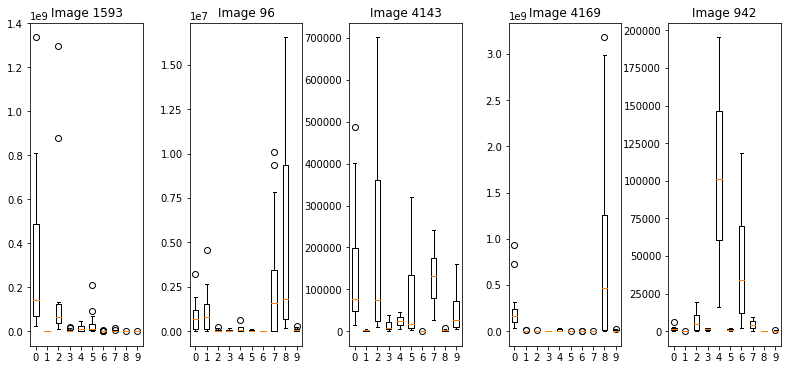

Test Hard-Voting Accuracy: 57.86%
Test Hard-Voting Accuracy-Over-Certainty: [60.30075187969924, 63.61629048086359, 67.37891737891738, 70.4211229946524, 75.0, 80.62111801242236]%
Test Soft-Voting Accuracy: 57.16%


/tmp/ipykernel_15397/170752579.py:63: RuntimeWarning: overflow encountered in exp
  probabilities = onp.exp(logits_all)


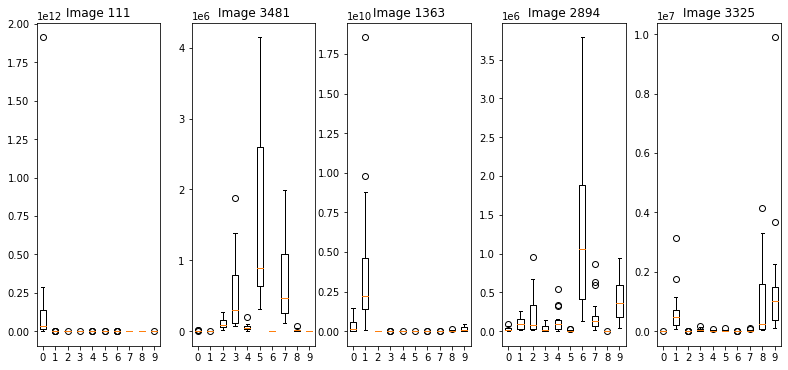

In [15]:
# Model evaluation
evaluate_model(results, train_loader, dataset="training")
evaluate_model(results, val_loader, dataset="validation")
evaluate_model(results, test_loader, dataset="test")